<a href="https://colab.research.google.com/github/GarryDarian/BNCC2101205_Garry-Darian/blob/main/Copy_of_my_version_of_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
kmader_skin_cancer_mnist_ham10000_path = kagglehub.dataset_download('kmader/skin-cancer-mnist-ham10000')

print('Data source import complete.')


100%|██████████| 5.20G/5.20G [02:13<00:00, 41.8MB/s]

Extracting files...


Data source import complete.


In [ ]:
import pandas as pd
import numpy as np
import os
import time
import shutil
import itertools
import random
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import sparse_categorical_crossentropy
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization,Dropout

from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
list = '/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/'
os.listdir(list)

['ham10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv',
 'ham10000_images_part_1',
 'hmnist_28_28_L.csv',
 'HAM10000_images_part_1',
 'HAM10000_images_part_2']

In [ ]:
data = pd.read_csv('/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/hmnist_28_28_RGB.csv')
data.head(3)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Columns: 2353 entries, pixel0000 to label
dtypes: int64(2353)
memory usage: 179.8 MB


In [ ]:
data.describe()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
count,10015.000000,10015.000000,10015.00000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,...,10015.00000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000
mean,181.056415,131.728407,141.24024,187.274488,137.089466,147.206191,192.358862,141.796405,152.211782,196.177234,...,184.68657,138.416875,144.061508,178.656216,133.217474,138.752172,172.307239,127.871193,133.144483,3.720919
std,59.746698,45.043473,48.67267,54.021274,41.138096,44.661091,48.267713,37.382709,40.725174,43.892249,...,47.02376,38.393007,41.322365,53.534096,42.910723,45.642257,58.533979,46.453818,49.060028,1.347499
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,158.000000,117.000000,123.00000,165.000000,122.000000,130.000000,170.000000,127.000000,135.000000,174.000000,...,166.00000,123.000000,126.000000,160.000000,118.000000,120.000000,153.000000,113.000000,115.000000,4.000000
50%,198.000000,141.000000,151.00000,201.000000,144.000000,155.000000,204.000000,146.000000,157.000000,205.000000,...,197.00000,144.000000,149.000000,195.000000,141.000000,146.000000,191.000000,138.000000,142.000000,4.000000
75%,224.000000,159.000000,172.00000,226.000000,162.000000,174.000000,227.000000,163.000000,177.000000,228.000000,...,216.00000,161.000000,169.000000,214.000000,159.000000,166.000000,212.000000,156.000000,163.000000,4.000000
max,255.000000,246.000000,255.00000,254.000000,246.000000,254.000000,255.000000,251.000000,255.000000,255.000000,...,255.00000,254.000000,254.000000,254.000000,252.000000,255.000000,254.000000,249.000000,254.000000,6.000000


<ipython-input-7-7dacaf22d829>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_values, y=label_names, palette='Paired', orient='h', linewidth=2)


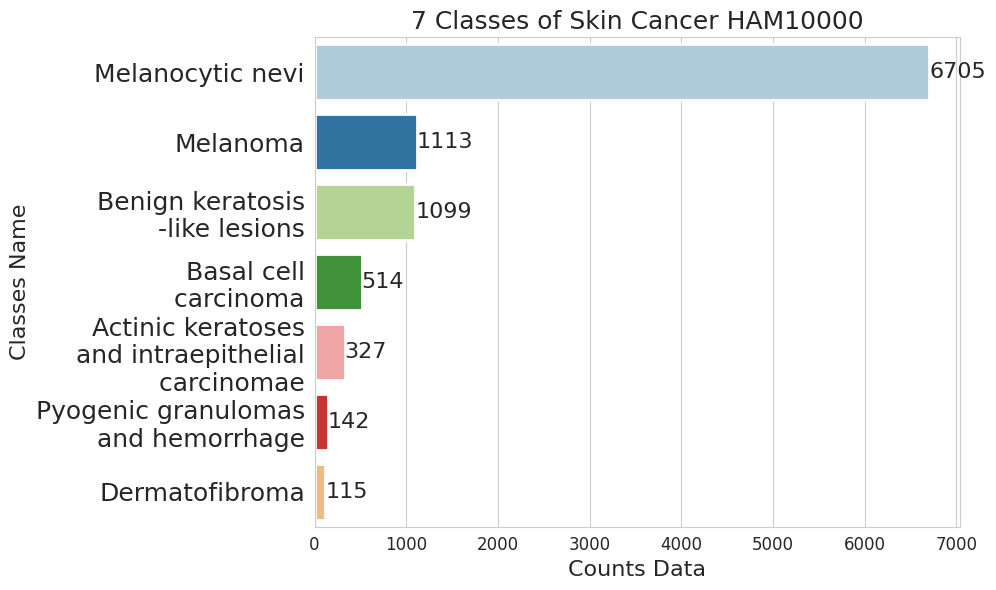

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Class mapping
classes = {4: ('nv', 'Melanocytic nevi'),
           6: ('mel', 'Melanoma'),
           2: ('bkl', 'Benign keratosis\n -like lesions'),
           1: ('bcc', 'Basal cell\n carcinoma'),
           5: ('vasc', 'Pyogenic granulomas\nand hemorrhage'),
           0: ('akiec', 'Actinic keratoses\nand intraepithelial\n carcinomae'),
           3: ('df', 'Dermatofibroma')}

# Label counts and mapping
Label = data["label"]
label_counts = Label.value_counts()
label_names = [classes[i][1] for i in label_counts.index]
label_values = label_counts.values

# Plot styling
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))  # Increase the width for more label space

# Horizontal bar chart
ax = sns.barplot(x=label_values, y=label_names, palette='Paired', orient='h', linewidth=2)

# Add value labels with larger fontsize
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=16)  # Larger font size for values on the bars

# Chart title and labels with larger fontsize
plt.title('7 Classes of Skin Cancer HAM10000', fontsize=18)
plt.xlabel('Counts Data', fontsize=16)
plt.ylabel('Classes Name', fontsize=16)

# Enlarge both X and Y axis labels
plt.xticks(fontsize=12)  # Label values on the X-axis
plt.yticks(fontsize=18)  # Enlarge font size of label_names on the Y-axis

# Adjust layout to avoid clipping
plt.tight_layout()

plt.show()


<ipython-input-8-1080c0700005>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_names, y=label_values, palette='Paired')


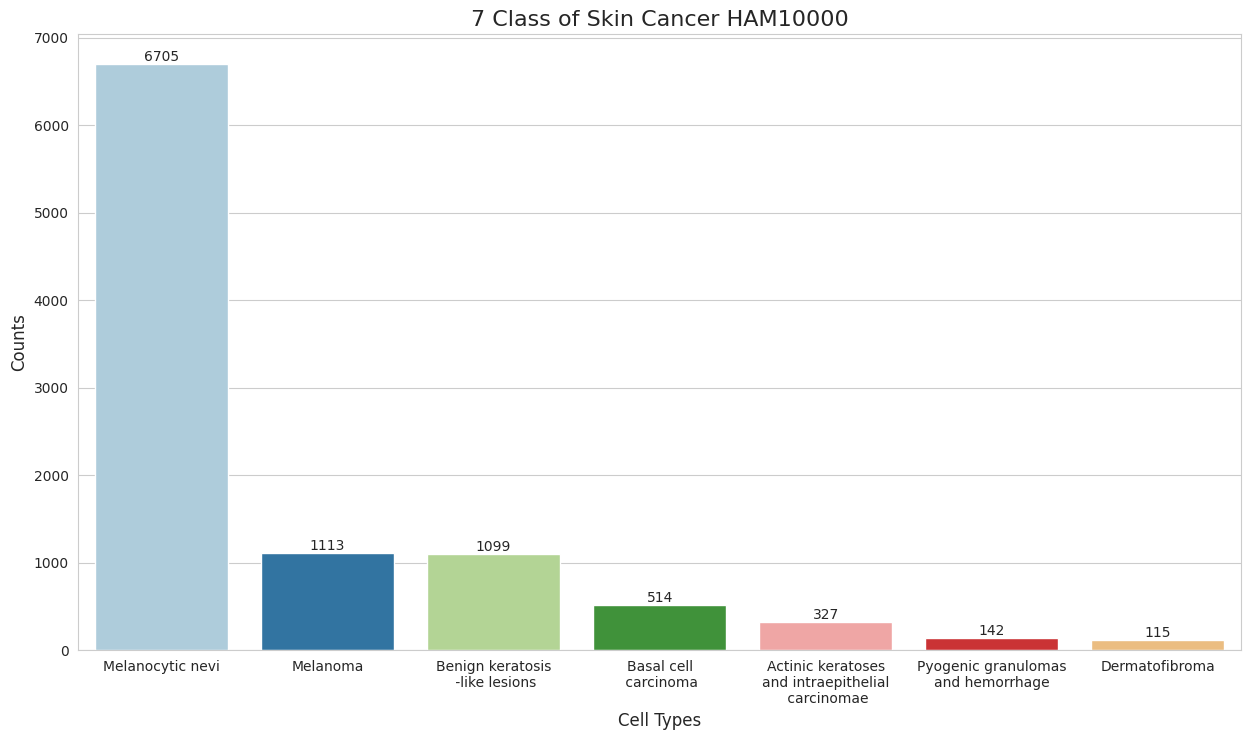

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

classes = {4: ('nv', 'Melanocytic nevi'),
           6: ('mel', 'Melanoma'),
           2: ('bkl', 'Benign keratosis\n -like lesions'),
           1: ('bcc', 'Basal cell\n carcinoma'),
           5: ('vasc', 'Pyogenic granulomas\nand hemorrhage'),
           0: ('akiec', 'Actinic keratoses\nand intraepithelial\n carcinomae'),
           3: ('df', 'Dermatofibroma')}

Label = data["label"]
label_counts = Label.value_counts()

label_names = [classes[i][1] for i in label_counts.index]
label_values = label_counts.values

sns.set_style('whitegrid')
plt.figure(figsize=(15, 8))
ax = sns.barplot(x=label_names, y=label_values, palette='Paired')

for container in ax.containers:
    ax.bar_label(container)

plt.title('7 Class of Skin Cancer HAM10000', fontsize=16)
plt.xlabel('Cell Types', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.show()

Original Data shape: (46935, 2352)


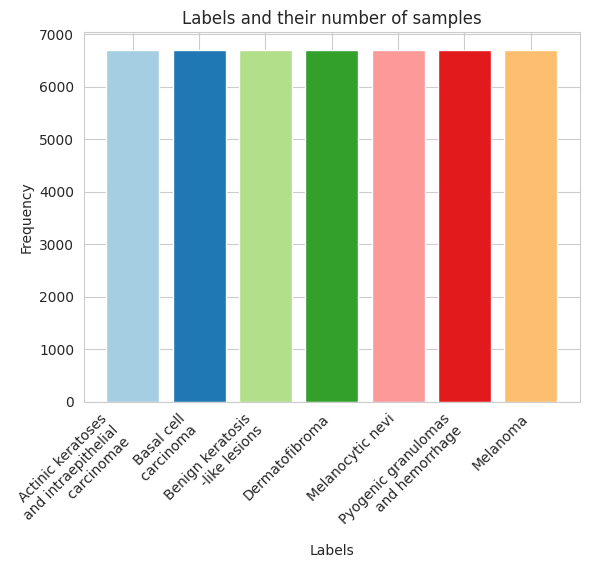

In [ ]:
from imblearn.over_sampling import RandomOverSampler  # augmentation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Mapping kelas dengan nama label
classes = {4: ('nv', 'Melanocytic nevi'),
           6: ('mel', 'Melanoma'),
           2: ('bkl', 'Benign keratosis\n -like lesions'),
           1: ('bcc', 'Basal cell\n carcinoma'),
           5: ('vasc', 'Pyogenic granulomas\nand hemorrhage'),
           0: ('akiec', 'Actinic keratoses\nand intraepithelial\n carcinomae'),
           3: ('df', 'Dermatofibroma')}

# Oversample data
Label = data["label"]
Data = data.drop(columns=["label"])
oversample = RandomOverSampler(random_state=42)
Data, Label = oversample.fit_resample(Data, Label)

# Pastikan data asli tetap dalam bentuk awal (tidak diubah bentuknya)
print('Original Data shape:', Data.shape)

Data = Data.to_numpy()
Label = Label.to_numpy()

def printDataBalance(Y):
    # Hitung jumlah data per label
    data = [0 for _ in range(7)]
    for i in Y:
        data[i] += 1

    # Ambil warna dari palette 'Paired'
    colors = sns.color_palette("Paired", n_colors=len(data))

    # Buat histogram dengan warna
    plt.bar(range(len(data)), data, color=colors)

    # Tambahkan label dan judul
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.title('Labels and their number of samples')

    # Sesuaikan ticks x-axis dengan nama kategori dari `classes`
    label_names = [classes[i][1] for i in range(len(data))]  # Ambil nama kelas dari dictionary
    plt.xticks(range(len(data)), label_names, rotation=45, ha='right')  # Label miring agar lebih terbaca

    plt.show()

# Panggil fungsi untuk visualisasi
printDataBalance(Label)

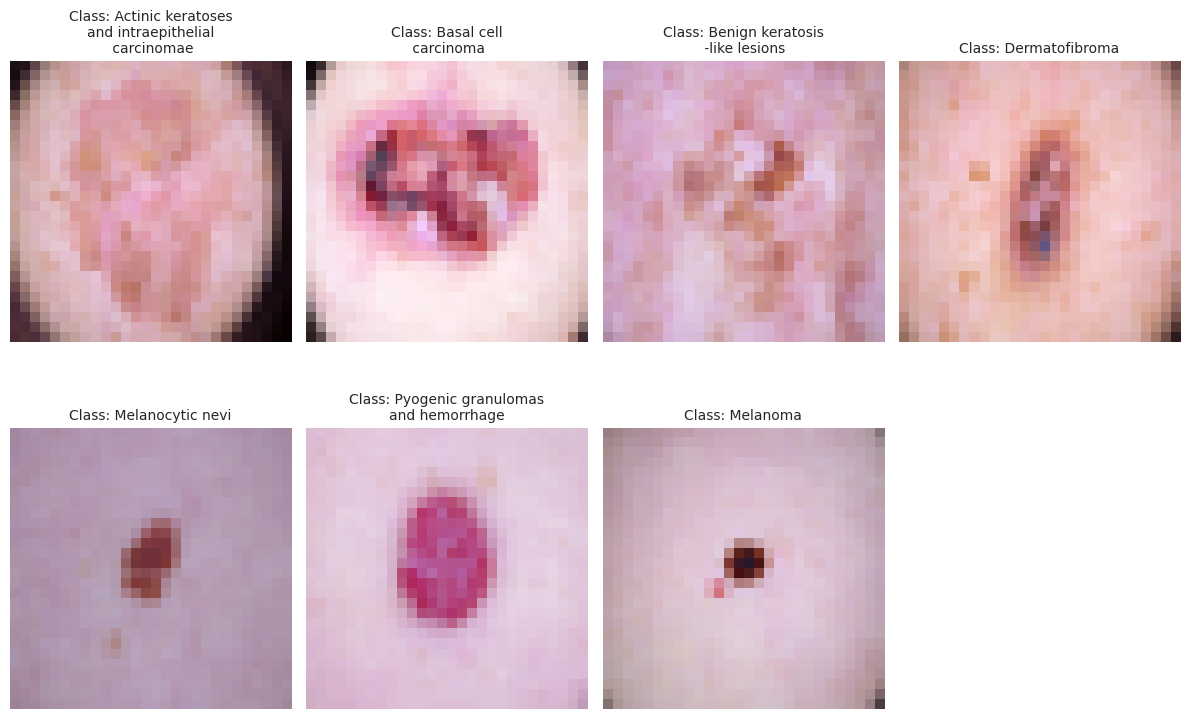

In [ ]:
from imblearn.over_sampling import RandomOverSampler  # augmentation
import numpy as np
import matplotlib.pyplot as plt

# Oversample data
Label = data["label"]
Data = data.drop(columns=["label"])
oversample = RandomOverSampler(random_state=42)
Data, Label = oversample.fit_resample(Data, Label)
# Pilih satu sampel dari setiap kategori
unique_labels = np.unique(Label)
samples = []

for label in unique_labels:
    idx = np.where(Label == label)[0][0]  # Ambil indeks pertama untuk label tersebut
    samples.append((Data.iloc[idx].values, label))  # Ambil nilai asli tanpa reshaping

# Plot hasilnya
plt.figure(figsize=(12, 8))
for i, (image, label) in enumerate(samples):
    # Ubah vektor kembali ke bentuk gambar asli jika diperlukan
    side_length = int(np.sqrt(len(image) // 3))  # Asumsi data RGB, hitung dimensi persegi
    image = image.reshape(side_length, side_length, 3).astype(np.uint8)

    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.title(f"Class: {classes[label][1]}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
Data = np.array(Data).reshape(-1, 28, 28, 3)
print('Shape of Data :', Data.shape)

Shape of Data : (46935, 28, 28, 3)


In [ ]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.25 , random_state = 49)
print('X_train :', X_train.shape)
print('y_train :', y_train.shape)
print('X_test :', X_test.shape)
print('y_test :', y_test.shape)

X_train : (35201, 28, 28, 3)
y_train : (35201,)
X_test : (11734, 28, 28, 3)
y_test : (11734,)


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('y_train :', y_train.shape)
print('y_test :', y_test.shape)

y_train : (35201, 7)
y_test : (11734, 7)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SeparableConv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

# Model architecture
def model_function():
    model = Sequential([
        # Convolutional layers
        SeparableConv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3), padding='same', depthwise_initializer='he_normal', pointwise_initializer='he_normal'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        SeparableConv2D(64, (3, 3), activation='relu', padding='same', depthwise_initializer='he_normal', pointwise_initializer='he_normal'),
        SeparableConv2D(64, (3, 3), activation='relu', padding='same', depthwise_initializer='he_normal', pointwise_initializer='he_normal'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        SeparableConv2D(128, (3, 3), activation='relu', padding='same', depthwise_initializer='he_normal', pointwise_initializer='he_normal'),
        SeparableConv2D(128, (3, 3), activation='relu', padding='same', depthwise_initializer='he_normal', pointwise_initializer='he_normal'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        SeparableConv2D(256, (3, 3), activation='relu', padding='same', depthwise_initializer='he_normal', pointwise_initializer='he_normal'),
        SeparableConv2D(256, (3, 3), activation='relu', padding='same', depthwise_initializer='he_normal', pointwise_initializer='he_normal'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        # Flatten and dense layers
        Flatten(),
        Dropout(rate=0.2),
        Dense(256, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dense(128, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dense(64, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.L1L2()),
        BatchNormalization(),

        # Output layer
        Dense(7, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Initialize and summarize the model
model = model_function()
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_separable_conv.py:104: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv2d (SeparableConv2D)   │ (None, 28, 28, 32)          │             155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_1 (SeparableConv2D) │ (None, 14, 14, 64)          │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_2 (SeparableConv2D) │ (None, 14, 14, 64)          │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_3 (SeparableConv2D) │ (None, 7, 7, 128)           │           8,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_4 (SeparableConv2D) │ (None, 7, 7, 128)           │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 3, 3, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_5 (SeparableConv2D) │ (None, 3, 3, 256)           │          34,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_6 (SeparableConv2D) │ (None, 3, 3, 256)           │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1, 1, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 249,218 (973.51 KB)

 Trainable params: 247,298 (966.01 KB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=500, rankdir='TB')

In [ ]:
from keras.callbacks import ReduceLROnPlateau

learning_rate = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            , factor=0.5
                                            , min_lr=0.00001)

model = model_function()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=128,callbacks=[learning_rate])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_separable_conv.py:104: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 78s 247ms/step - accuracy: 0.4692 - loss: 1.4428 - val_accuracy: 0.1407 - val_loss: 2.8968 - learning_rate: 0.0010
Epoch 2/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 65s 234ms/step - accuracy: 0.7979 - loss: 0.5613 - val_accuracy: 0.1972 - val_loss: 2.8034 - learning_rate: 0.0010
Epoch 3/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 64s 231ms/step - accuracy: 0.8788 - loss: 0.3412 - val_accuracy: 0.8816 - val_loss: 0.3273 - learning_rate: 0.0010
Epoch 4/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 86s 245ms/step - accuracy: 0.9037 - loss: 0.2660 - val_accuracy: 0.8590 - val_loss: 0.3925 - learning_rate: 0.0010
Epoch 5/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 69s 249ms/step - accuracy: 0.9216 - loss: 0.2168 - val_accuracy: 0.9241 - val_loss: 0.2199 - learning_rate: 0.0010
Epoch 6/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 65s 236ms/step - accuracy: 0.9411 - loss: 0.1669 - val_accuracy: 0.9306 - val_loss: 0.1926 - learning_rate: 0.0010
Epoch 7/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 84s 244ms/step - accuracy: 0.9

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluasi model pada test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Ambil data dari fitting stats
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Menentukan indeks epoch dengan loss terkecil dan accuracy tertinggi
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]


367/367 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9825 - loss: 0.0786
Test Accuracy: 0.9815067052841187


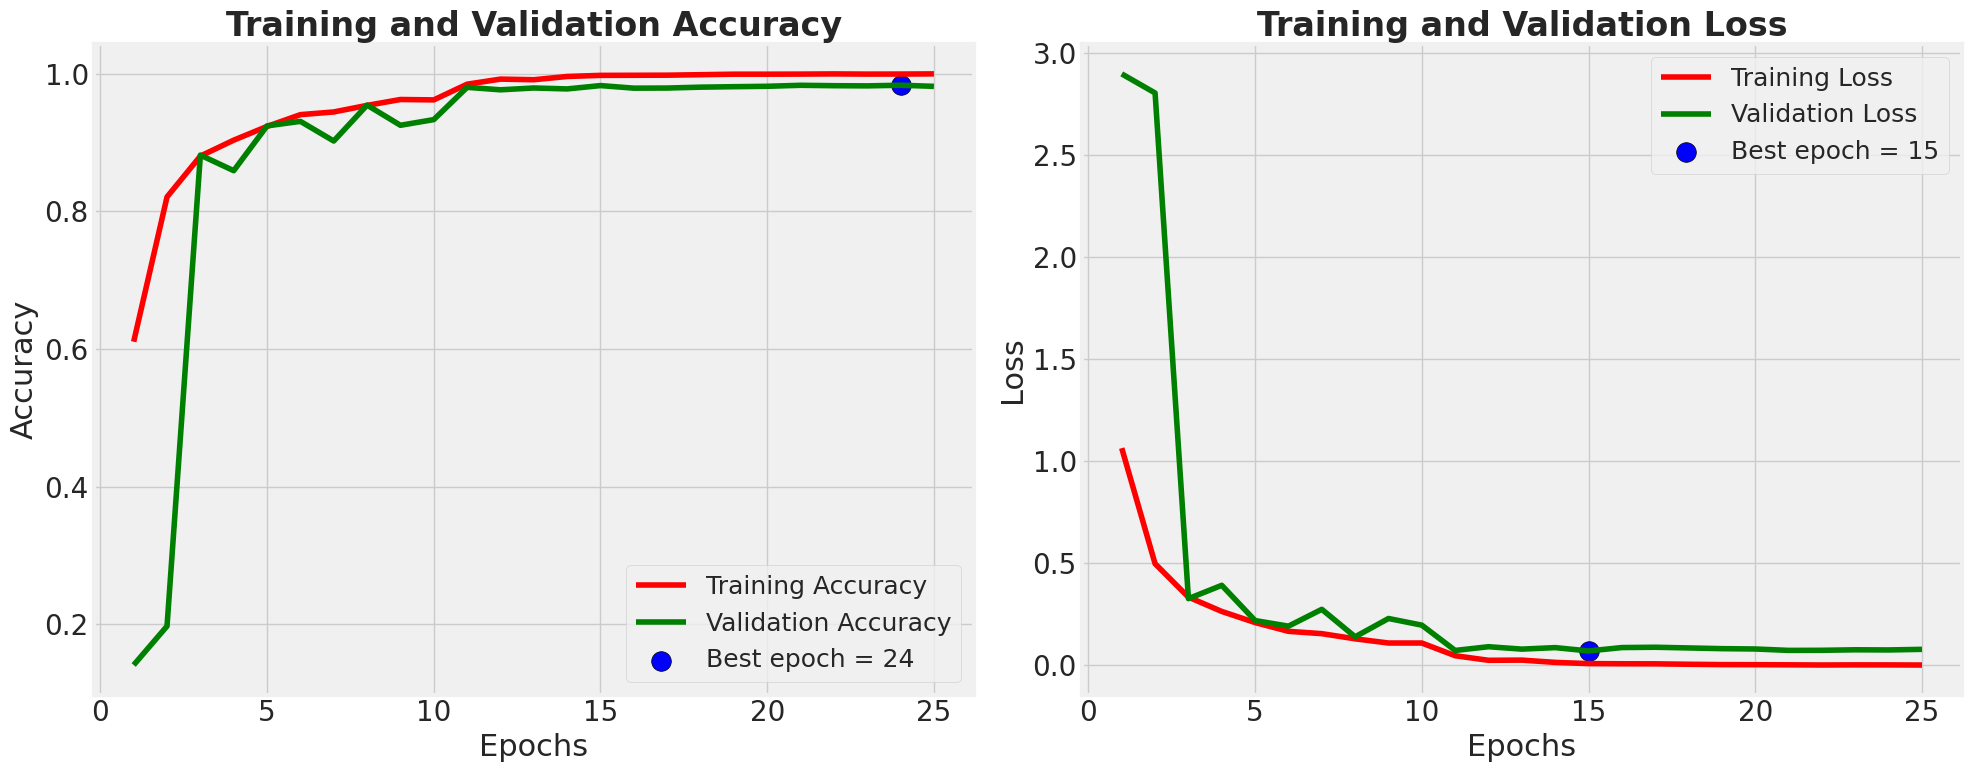

In [ ]:
# Plot training dan validation metrics
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

# Atur ukuran font secara global
plt.rcParams.update({'font.size': 16})

Epochs = [i + 1 for i in range(len(acc))]
loss_label = f'Best epoch = {index_loss + 1}'
acc_label = f'Best epoch = {index_acc + 1}'

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(Epochs, acc, 'r', label='Training Accuracy', linewidth=4)
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy', linewidth=4)
plt.scatter(index_acc + 1, acc_highest, s=200, c='blue', label=acc_label, edgecolors='black')
plt.title('Training and Validation Accuracy', fontsize=24, fontweight='bold')
plt.xlabel('Epochs', fontsize=22)
plt.ylabel('Accuracy', fontsize=22)
plt.legend(fontsize=18)
plt.grid(True)

# Perbesar angka pada sumbu X dan Y
plt.tick_params(axis='both', labelsize=20)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(Epochs, loss, 'r', label='Training Loss', linewidth=4)
plt.plot(Epochs, val_loss, 'g', label='Validation Loss', linewidth=4)
plt.scatter(index_loss + 1, val_lowest, s=200, c='blue', label=loss_label, edgecolors='black')
plt.title('Training and Validation Loss', fontsize=24, fontweight='bold')
plt.xlabel('Epochs', fontsize=22)
plt.ylabel('Loss', fontsize=22)
plt.legend(fontsize=18)
plt.grid(True)

# Perbesar angka pada sumbu X dan Y
plt.tick_params(axis='both', labelsize=20)

plt.tight_layout()
plt.show()

In [ ]:
train_score = model.evaluate(X_train, y_train, verbose= 1)
test_score = model.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1101/1101 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 1.0000 - loss: 1.3311e-04
367/367 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9825 - loss: 0.0786
Train Loss:  0.00012942857574671507
Train Accuracy:  1.0
--------------------
Test Loss:  0.07902618497610092
Test Accuracy:  0.9815067052841187


In [ ]:
y_true = np.array(y_test)
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

367/367 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


In [ ]:
classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

print(classes_labels)

[4, 6, 2, 1, 5, 0, 3]


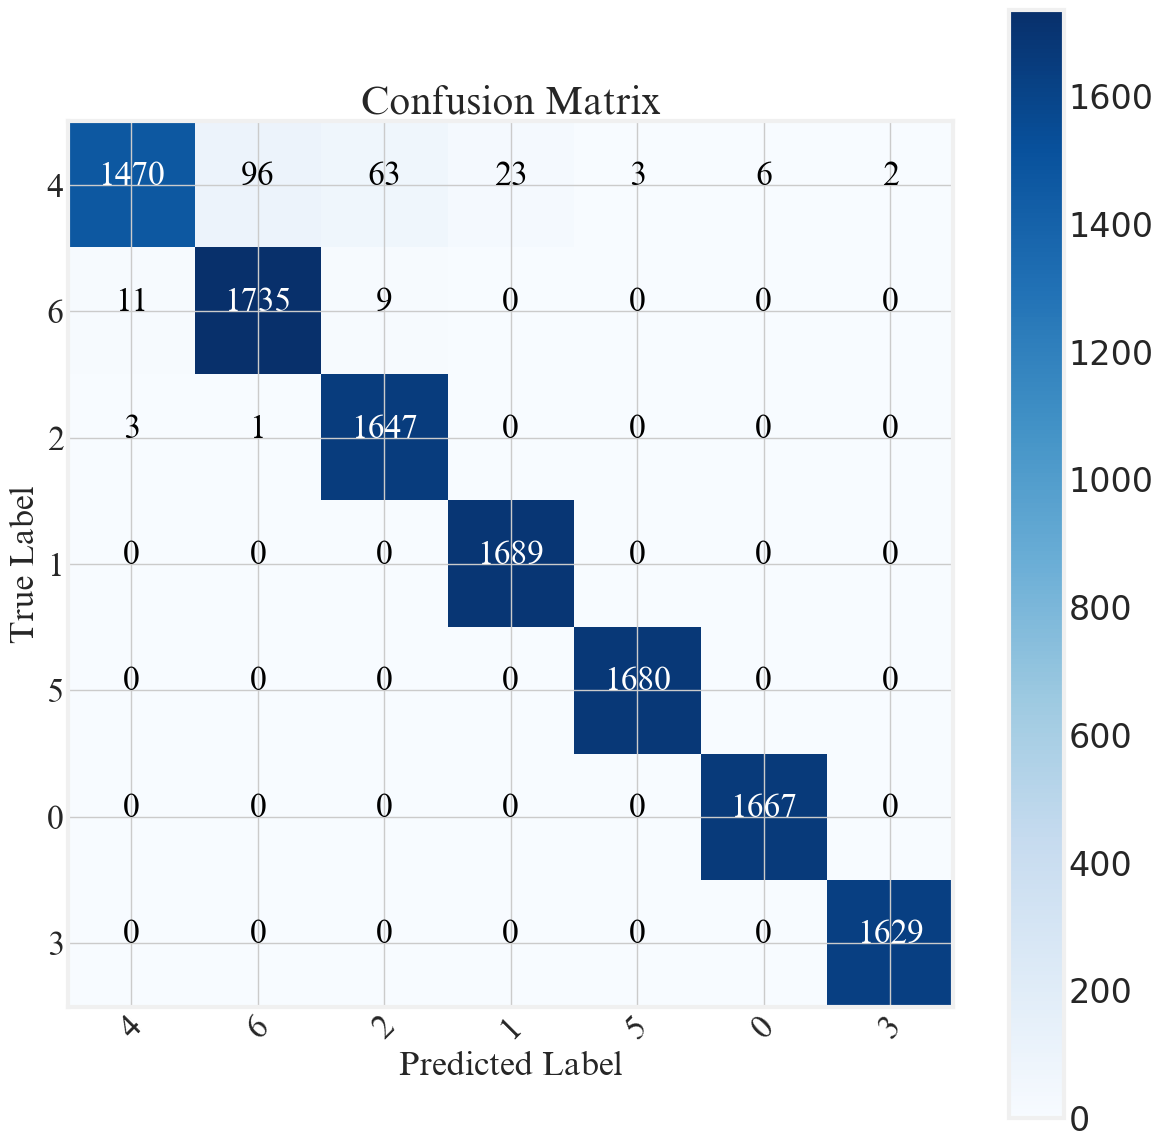

In [ ]:
cm = cm = confusion_matrix(y_true, y_pred, labels=classes_labels)

import numpy as np
import matplotlib.pyplot as plt
import itertools
import matplotlib.font_manager as fm
from sklearn.metrics import confusion_matrix



plt.rcParams.update({
    'font.size': 24,  # Ukuran default untuk semua teks
    'axes.titlesize': 24,  # Ukuran title
    'axes.labelsize': 24,  # Ukuran label sumbu
    'xtick.labelsize': 24,  # Ukuran angka pada sumbu X
    'ytick.labelsize': 24,  # Ukuran angka pada sumbu Y
    'legend.fontsize': 24,  # Ukuran legend
})

# Set path font secara manual (Windows/Linux)
font_path = "/content/times new roman.ttf"  # Sesuaikan path jika berbeda
font_prop = fm.FontProperties(fname=font_path)

# Plot Confusion Matrix
plt.figure(figsize=(12, 12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues) # Create the plot first
plt.title('Confusion Matrix', fontproperties=font_prop, fontsize=28)
cbar = plt.colorbar() # Now call colorbar

cbar.ax.tick_params(labelsize=24)  # Perbesar angka pada colorbar


tick_marks = np.arange(len(classes_labels))
plt.xticks(tick_marks, classes_labels, rotation=45, fontproperties=font_prop, fontsize=24)
plt.yticks(tick_marks, classes_labels, fontproperties=font_prop, fontsize=24)

# Menampilkan angka pada Confusion Matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center',
             fontproperties=font_prop, fontsize=24,  # Perbesar angka dalam matrix
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label', fontproperties=font_prop, fontsize=24)
plt.xlabel('Predicted Label', fontproperties=font_prop, fontsize=24)

plt.show()

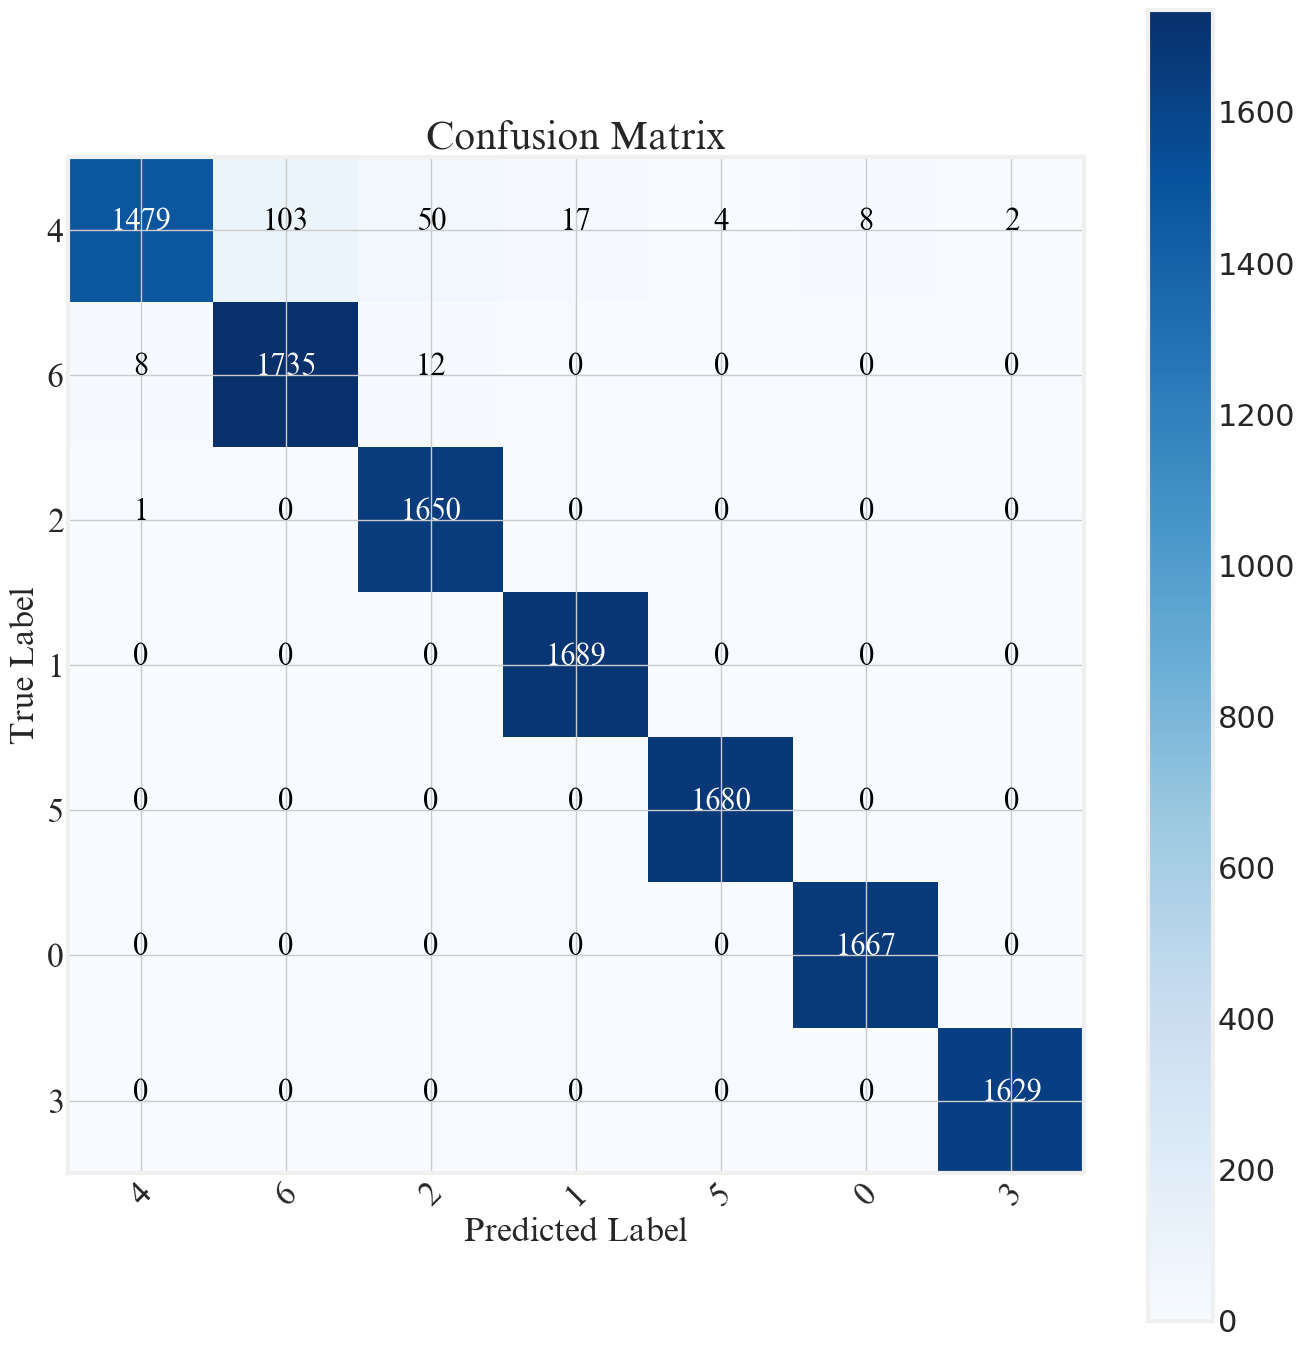

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import matplotlib.font_manager as fm
from sklearn.metrics import confusion_matrix

# Simulasi data sesuai dengan angka yang terlihat pada gambar
cm = np.array([
    [1479, 103, 50, 17, 4, 8, 2],
    [8, 1735, 12, 0, 0, 0, 0],
    [1, 0, 1650, 0, 0, 0, 0],
    [0, 0, 0, 1689, 0, 0, 0],
    [0, 0, 0, 0, 1680, 0, 0],
    [0, 0, 0, 0, 0, 1667, 0],
    [0, 0, 0, 0, 0, 0, 1629]
])

classes_labels = ["4", "6", "2", "1", "5", "0", "3"]

# Atur ukuran font global
plt.rcParams.update({
    'font.size': 24,  # Ukuran default untuk semua teks
    'axes.titlesize': 24,  # Ukuran title
    'axes.labelsize': 24,  # Ukuran label sumbu
    'xtick.labelsize': 24,  # Ukuran angka pada sumbu X
    'ytick.labelsize': 24,  # Ukuran angka pada sumbu Y
    'legend.fontsize': 24,  # Ukuran legend
})

# Set path font secara manual (Windows/Linux)
font_path = "/content/times new roman.ttf"  # Sesuaikan path jika berbeda
font_prop = fm.FontProperties(fname=font_path)

# Plot Confusion Matrix
plt.figure(figsize=(14, 14))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontproperties=font_prop, fontsize=28)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=22)  # Perbesar angka pada colorbar

tick_marks = np.arange(len(classes_labels))
plt.xticks(tick_marks, classes_labels, rotation=45, fontproperties=font_prop, fontsize=24)
plt.yticks(tick_marks, classes_labels, fontproperties=font_prop, fontsize=24)

# Menampilkan angka pada Confusion Matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center',
             fontproperties=font_prop, fontsize=22,
             color='white' if cm[i, j] > thresh else 'black')

plt.ylabel('True Label', fontproperties=font_prop, fontsize=24)
plt.xlabel('Predicted Label', fontproperties=font_prop, fontsize=24)

plt.tight_layout()
plt.show()


In [ ]:
model.save('Lite_Skin_Cancer_Me.h5')

In [ ]:
# Convert the Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # Use the in-memory model
tflite_model = converter.convert()

# Save the .tflite model to a file
with open('Lite_Skin_Cancer_Me.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model has been saved in TensorFlow Lite format as 'Skin_Cancer.tflite'.")


Saved artifact at '/tmp/tmpqtb9dpn3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float32, name='keras_tensor_27')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  136759118852944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136759085811280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136759085811856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136759109387856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136759109386704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136759085812816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136759109388432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136759109389776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136759109390736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136759109389008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1367591093901

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0 ('akiec', 'Actinic keratoses\nand intraepithelial\n carcinomae')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0 ('akiec', 'Actinic keratoses\nand intraepithelial\n carcinomae')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0 ('akiec', 'Actinic keratoses\nand intraepithelial\n carcinomae')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1 ('bcc', 'Basal cell\n carcinoma')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1 ('bcc', 'Basal cell\n carcinoma')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6 ('mel', 'Melanoma')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1 ('bcc', 'Basal cell\n carcinoma')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2 ('bkl', 'Benign keratosis\n -like lesions')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4 ('nv', 'Melanocytic nevi')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1 ('bcc', 'Basal cell\n carcinoma')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6 ('mel', 'Melanoma')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4 ('nv', 'Melanocytic nevi')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4 ('nv', 'Mel

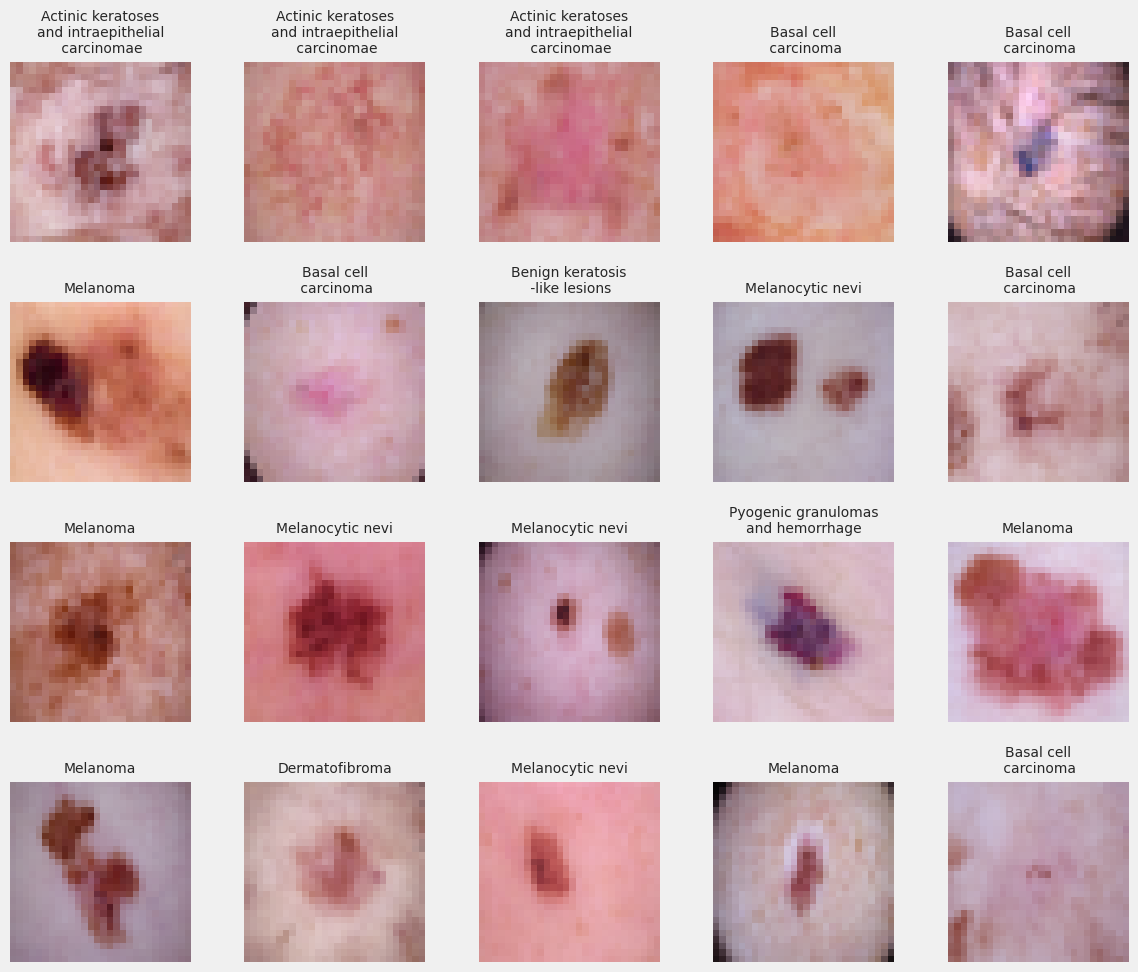

In [ ]:
indices=[]
ans=[]
for i in range(20):
    ind= random.randint(1,10000)
    label=np.argmax(model.predict(X_test[ind].reshape(-1,28,28,3)))
    print(label,classes[label])
    indices.append(ind)
    ans.append(label)
fig, axes = plt.subplots(4, 5, figsize=(12, 10))
axes = axes.flatten()
for i, image in enumerate(X_test[indices]):
    ax = axes[i]
    ax.imshow(image)
    ax.set_title(classes[ans[i]][1],fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()

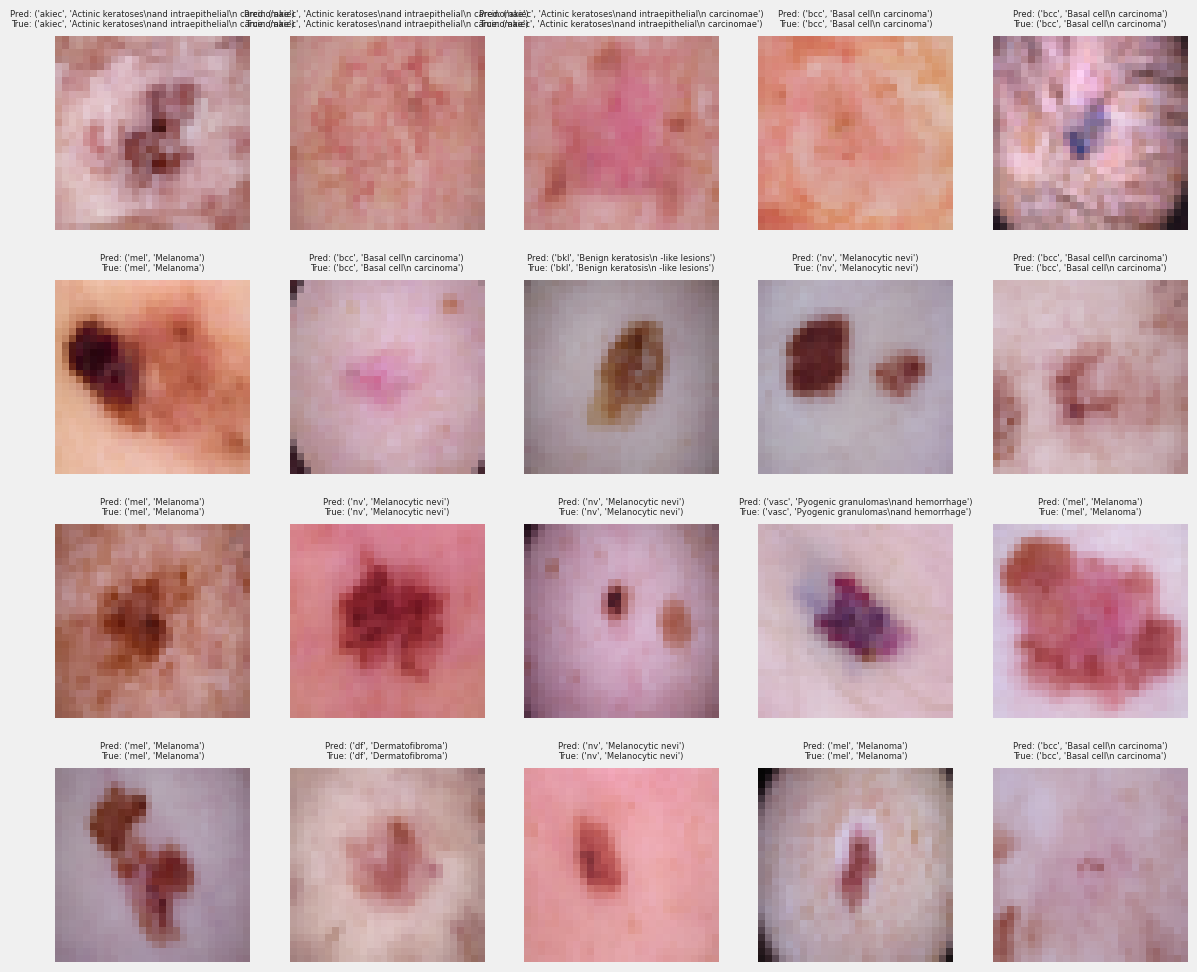

In [ ]:

# Plot the images with predictions
fig, axes = plt.subplots(4, 5, figsize=(12, 10))
axes = axes.flatten()

for i, image in enumerate(X_test[indices]):
    ax = axes[i]
    ax.imshow(image)
    ax.set_title(f"Pred: {classes[ans[i]]}\nTrue: {classes[np.argmax(y_test[indices[i]])]}", fontsize=6)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define the classes
classes = {0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           1: ('bcc', 'Basal cell carcinoma'),
           2: ('bkl', 'Benign keratosis-like lesions'),
           3: ('df', 'Dermatofibroma'),
           4: ('nv', 'Melanocytic nevi'),
           5: ('vasc', 'Pyogenic granulomas and hemorrhage'),
           6: ('mel', 'Melanoma')}

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/Lite_Skin_Cancer_Me.tflite")  # Update path sesuai lokasi model
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Preprocessing function
def preprocess_image(img_path):
    """
    Load and preprocess the image.
    Args:
        img_path (str): Path to the image.
    Returns:
        numpy.ndarray: Preprocessed image array.
    """
    image = tf.keras.preprocessing.image.load_img(img_path, target_size=(28, 28))  # Resize to target size
    image = tf.keras.preprocessing.image.img_to_array(image)  # Convert image to array
    image = image.reshape(input_details[0]['shape'])  # Reshape for the model input
    return image

# Predict function
def predict_image(img_path):
    """
    Predict the class of the given image using the TFLite model.
    Args:
        img_path (str): Path to the image.
    Returns:
        tuple: Predicted class, accuracy, and all class probabilities.
    """
    image = preprocess_image(img_path)  # Preprocess the image

    # Set the tensor input
    interpreter.set_tensor(input_details[0]['index'], image)

    # Run the TFLite model
    interpreter.invoke()

    # Get the predictions
    prediction = interpreter.get_tensor(output_details[0]['index'])[0]
    predicted_class = np.argmax(prediction)  # Class with the highest probability
    accuracy = np.max(prediction)  # Confidence level
    return predicted_class, accuracy, prediction

# Main program
if __name__ == "__main__":
    # Define the image path directly in the code
    img_path = '/content/ISIC_0029309.jpg'  # Update with the correct path to your image

    try:
        # Predict the image
        predicted_class, accuracy, prediction = predict_image(img_path)

        # Display the result
        print(f"\nPredicted Class: {classes[predicted_class][1]} ({classes[predicted_class][0]})")
        print(f"Accuracy: {accuracy * 100:.2f}%\n")
        print("Class Probabilities:")
        for idx, prob in enumerate(prediction):
            print(f"{classes[idx][1]} ({classes[idx][0]}): {prob:.4f}")

        # Display the image with prediction
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(28, 28))
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f"Prediction: {classes[predicted_class][1]}\nAccuracy: {accuracy:.4f}")
        plt.axis('off')
        plt.show()

    except FileNotFoundError:
        print("Error: File not found. Please check the path and try again.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


Error: File not found. Please check the path and try again.


Test Accuracy: 98.151%
367/367 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step
              precision    recall  f1-score   support

           k       1.00      1.00      1.00      1667
           c       0.99      1.00      0.99      1689
           k       0.96      1.00      0.98      1651
           f       1.00      1.00      1.00      1629
           v       0.99      0.88      0.93      1663
           a       1.00      1.00      1.00      1680
           e       0.95      0.99      0.97      1755

    accuracy                           0.98     11734
   macro avg       0.98      0.98      0.98     11734
weighted avg       0.98      0.98      0.98     11734



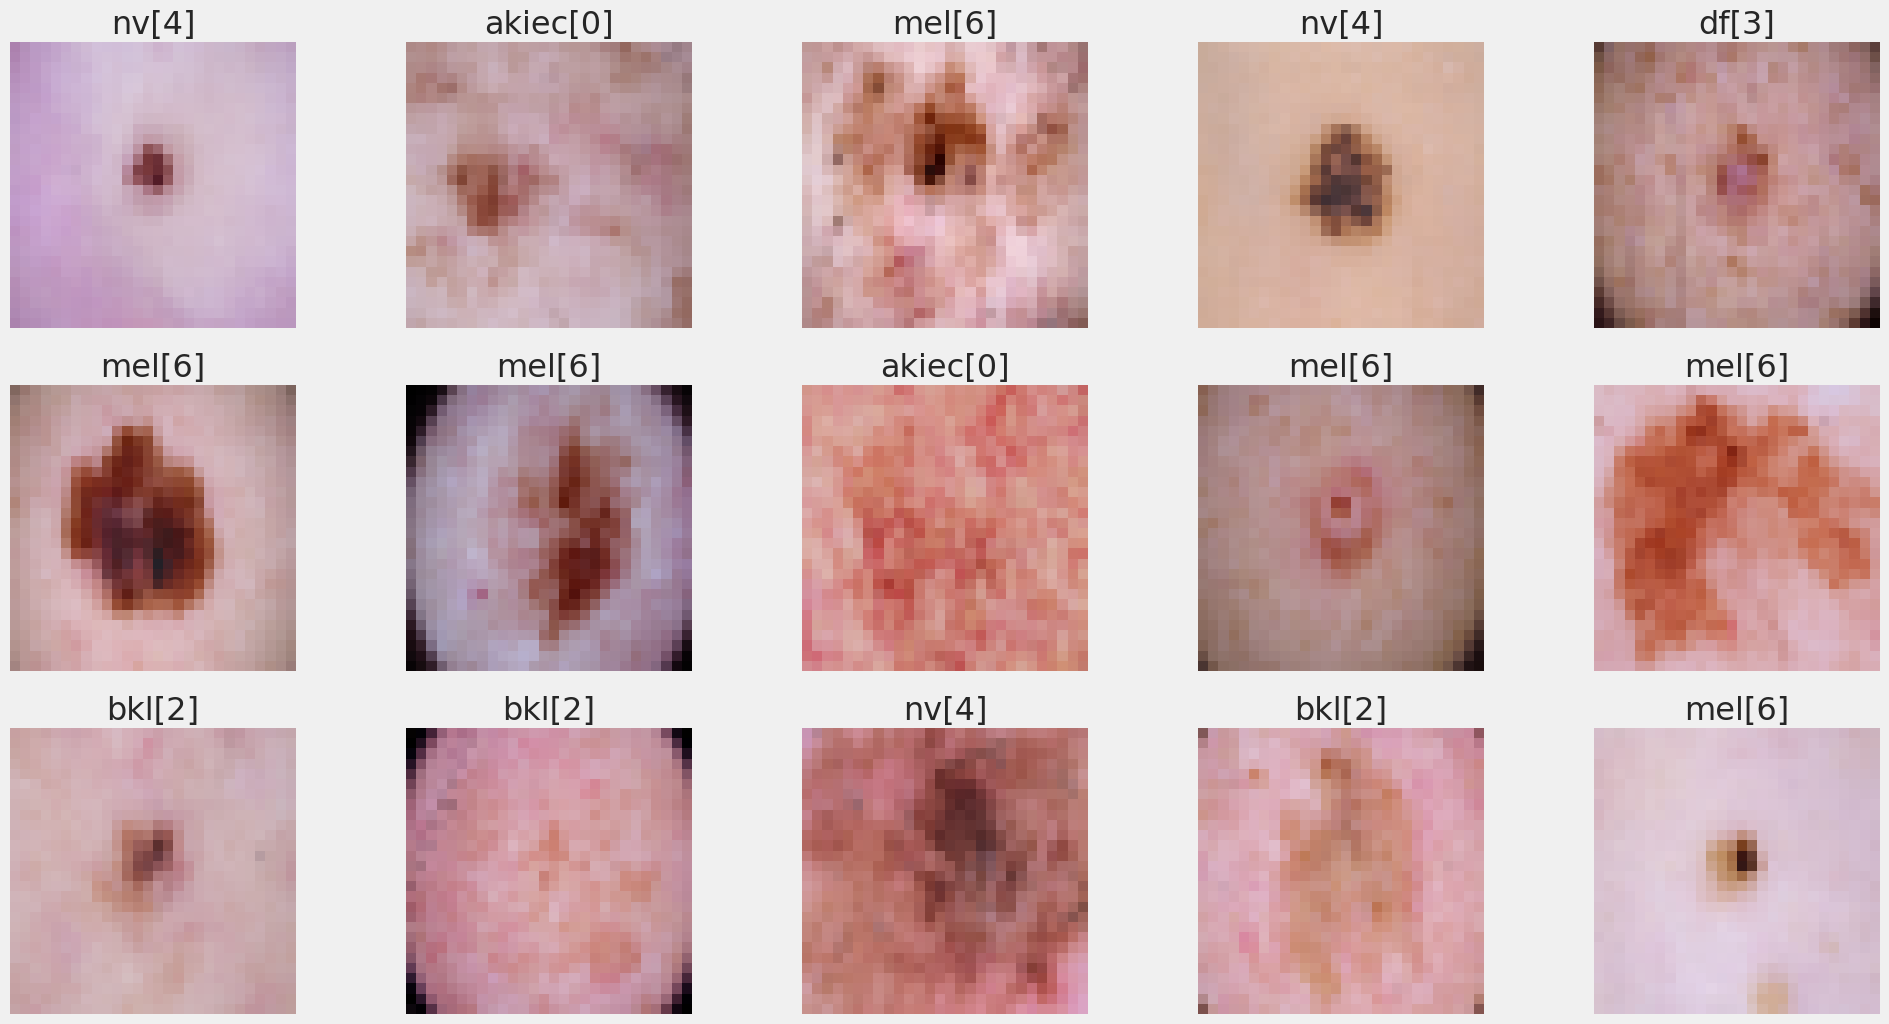

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

classes = {0: ('akiec'),
           1: ('bcc'),
           2: ('bkl'),
           3: ('df'),
           4: ('nv'),
           5: ('vasc'),
           6: ('mel')}

def test_model(model, X_test, Y_test):
    # Evaluate model accuracy
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))

    y_true = np.argmax(Y_test, axis=1)
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)


    # Print classification report
    clr = classification_report(y_true, y_pred, target_names=[classes[i][1] for i in range(len(classes))])
    print(clr)

    # Display sample images with true vs predicted labels
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(f"{classes[y_pred[i]]}[{y_pred[i]}]")
        plt.axis("off")
    plt.show()

test_model(model, X_test, y_test)

In [ ]:
import tensorflow.lite as tflite

# Load model TFLite
interpreter = tflite.Interpreter(model_path="/content/Lite_Skin_Cancer_Me.tflite")
interpreter.allocate_tensors()

# Ambil informasi input tensor
input_details = interpreter.get_input_details()

# Cek bentuk (shape) input tensor
print("Input shape:", input_details[0]['shape'])


Input shape: [ 1 28 28  3]


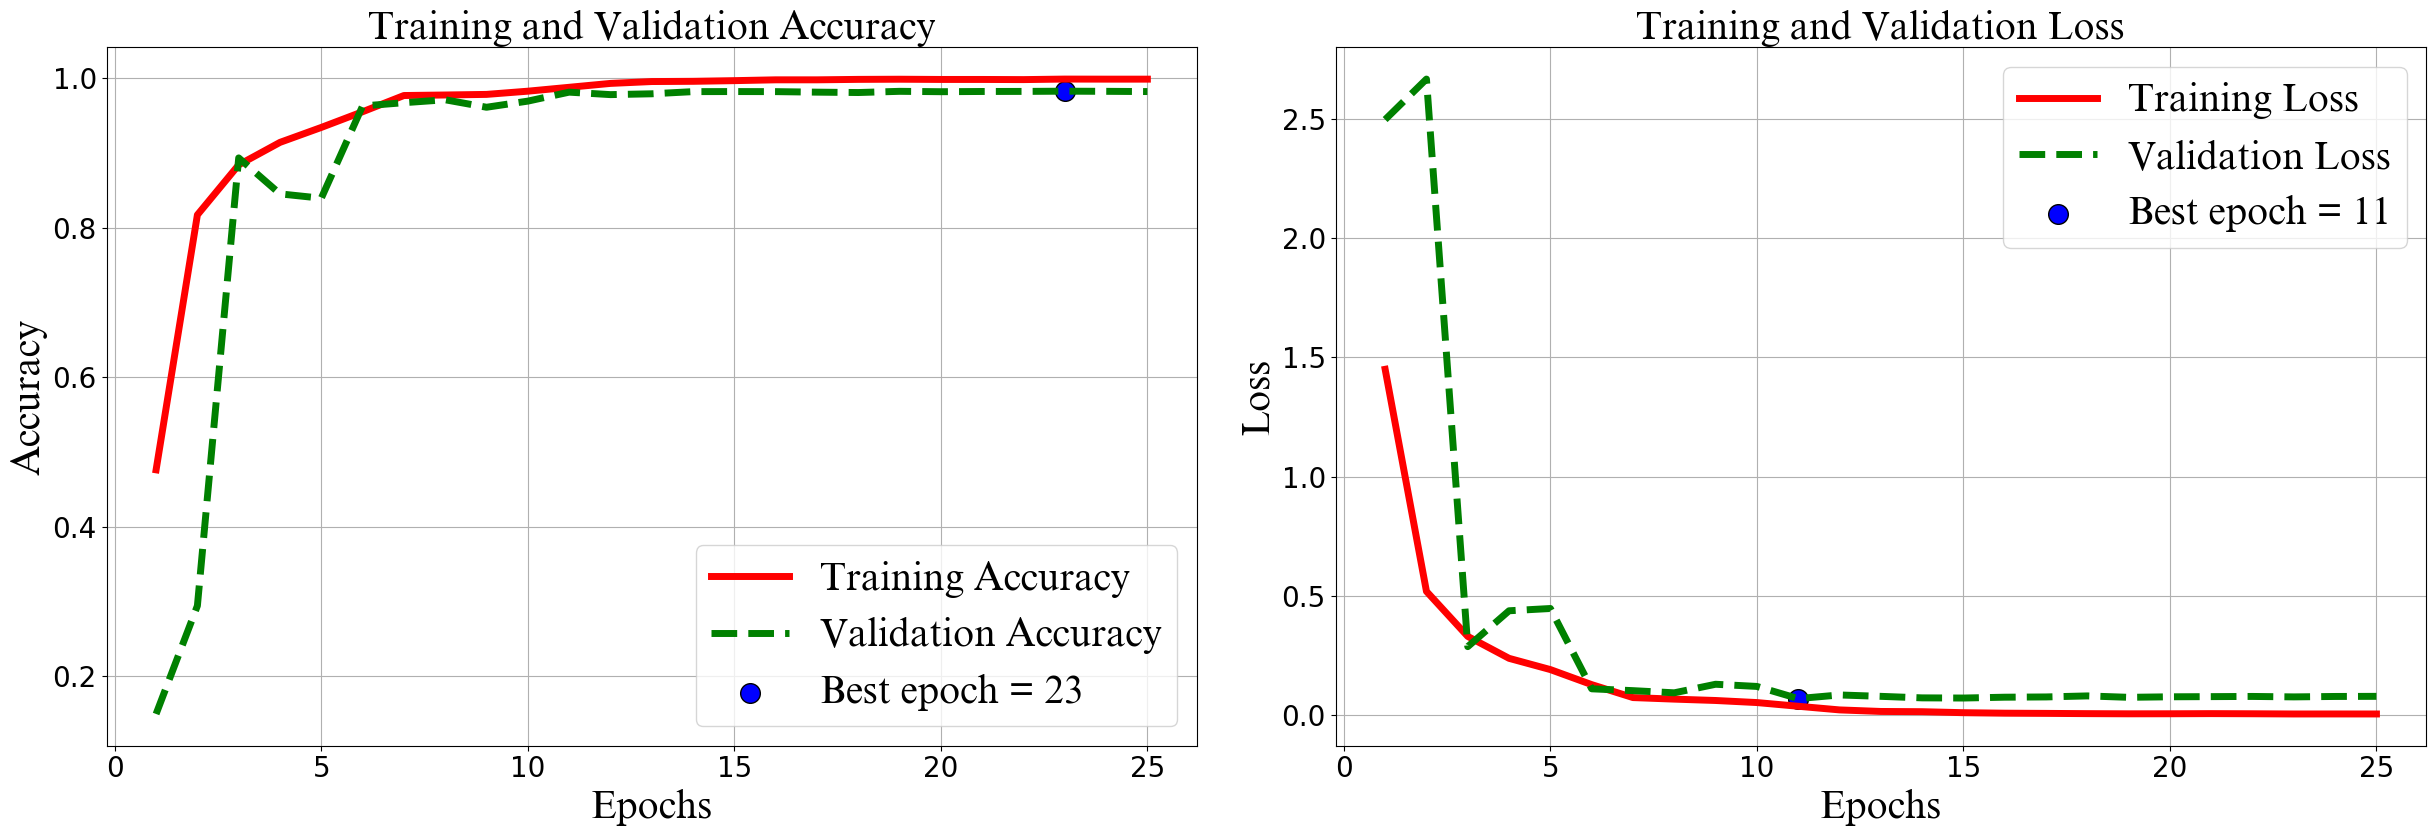

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.font_manager as fm

# Set path font secara manual (Windows)
font_path = "/content/times new roman.ttf"  # Sesuaikan path jika berbeda
font_prop = fm.FontProperties(fname=font_path)

# Data dari training log
acc = [0.4763, 0.8175, 0.8844, 0.9145, 0.9345, 0.9555, 0.9772, 0.9779, 0.9787, 0.9830, 0.9882, 0.9934, 0.9959, 0.9962, 0.9971, 0.9982, 0.9982, 0.9988, 0.9990, 0.9987, 0.9987, 0.9985, 0.9992, 0.9991, 0.9991]
val_acc = [0.1496, 0.2944, 0.8937, 0.8456, 0.8398, 0.9632, 0.9676, 0.9715, 0.9615, 0.9697, 0.9817, 0.9784, 0.9795, 0.9824, 0.9825, 0.9824, 0.9817, 0.9812, 0.9828, 0.9823, 0.9826, 0.9827, 0.9830, 0.9828, 0.9825]
loss = [1.4503, 0.5184, 0.3294, 0.2374, 0.1902, 0.1271, 0.0727, 0.0662, 0.0605, 0.0518, 0.0363, 0.0210, 0.0145, 0.0135, 0.0093, 0.0072, 0.0064, 0.0053, 0.0046, 0.0048, 0.0054, 0.0048, 0.0039, 0.0040, 0.0039]
val_loss = [2.4983, 2.6682, 0.2865, 0.4370, 0.4465, 0.1095, 0.1018, 0.0927, 0.1286, 0.1195, 0.0685, 0.0837, 0.0779, 0.0715, 0.0708, 0.0743, 0.0754, 0.0797, 0.0738, 0.0760, 0.0767, 0.0775, 0.0756, 0.0774, 0.0779]

# Menentukan indeks epoch dengan loss terkecil dan accuracy tertinggi
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

# Plot training dan validation metrics
plt.figure(figsize=(25, 9))
plt.rcParams.update({'font.size': 28})

Epochs = [i + 1 for i in range(len(acc))]
loss_label = f'Best epoch = {index_loss + 1}'
acc_label = f'Best epoch = {index_acc + 1}'

# Plot Accuracy
import matplotlib.pyplot as plt


# Atur font menjadi Times New Roman secara global
# plt.rcParams.update({'font.family': 'serif', 'font.serif': ['Times New Roman'], 'font.size': 16})


# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(Epochs, acc, 'r', label='Training Accuracy', linewidth=5)
plt.plot(Epochs, val_acc, 'g--', label='Validation Accuracy', linewidth=5)
plt.scatter(index_acc + 1, acc_highest, s=200, c='blue', label=acc_label, edgecolors='black')
plt.title('Training and Validation Accuracy', fontproperties=font_prop, fontsize=28)
plt.xlabel('Epochs', fontproperties=font_prop, fontsize=28)
plt.ylabel('Accuracy', fontproperties=font_prop, fontsize=28)
plt.legend(prop=font_prop, fontsize=40)
plt.grid(True)

# Perbesar angka pada sumbu X dan Y
plt.tick_params(axis='both', labelsize=20)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(Epochs, loss, 'r', label='Training Loss', linewidth=5)
plt.plot(Epochs, val_loss, 'g--', label='Validation Loss', linewidth=5)
plt.scatter(index_loss + 1, val_lowest, s=200, c='blue', label=loss_label, edgecolors='black')
plt.title('Training and Validation Loss', fontproperties=font_prop, fontsize=28)
plt.xlabel('Epochs', fontproperties=font_prop, fontsize=28)
plt.ylabel('Loss', fontproperties=font_prop, fontsize=28)
plt.legend(prop=font_prop, fontsize=40)
plt.grid(True)

# Perbesar angka pada sumbu X dan Y
plt.tick_params(axis='both', labelsize=20)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

